In [9]:
import pickle
import os, sys
import numpy as np
import xarray as xr
from joblib import Parallel, delayed


In [10]:
import qmap
print(dir(qmap))


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__']


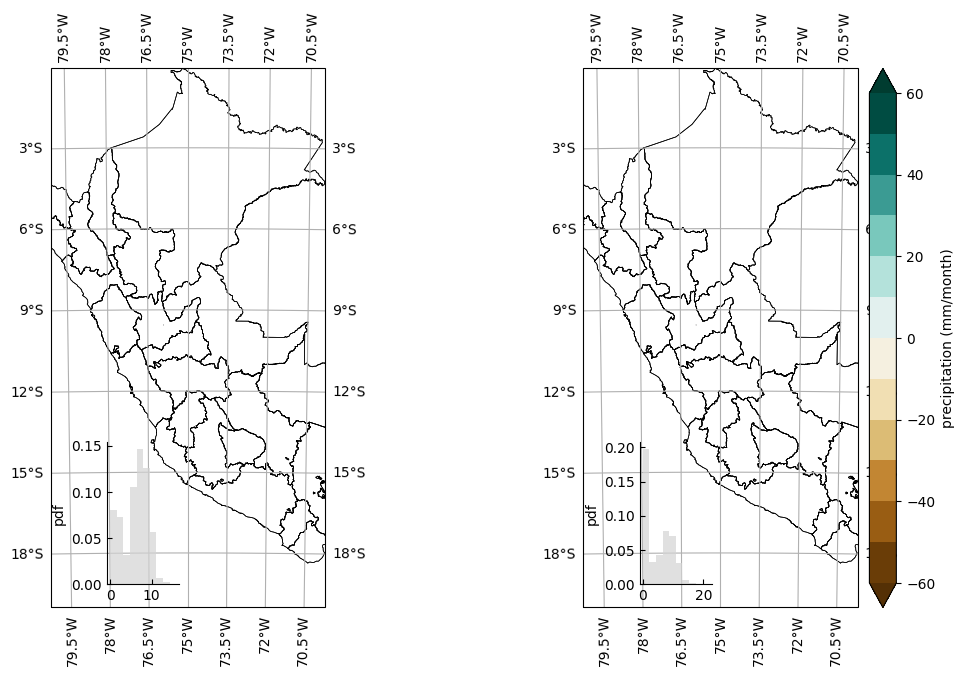

In [20]:
import os
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.io.shapereader import Reader
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Configuración de advertencias
warnings.filterwarnings("ignore")

# Rutas de los archivos shapefile
shp_nine = 'D:/T_JONA/TESIS_PISCO/DEPARTAMENTOS.shp'
shp_chn = 'D:/T_JONA/TESIS_PISCO/DEPARTAMENTOS.shp'
proj = ccrs.PlateCarree()  # Crear sistema de coordenadas
chnreader = Reader(shp_chn)
china = cfeature.ShapelyFeature(chnreader.geometries(), proj, edgecolor='k', facecolor='none')
nlreader = Reader(shp_nine)
ninel = cfeature.ShapelyFeature(nlreader.geometries(), proj, edgecolor='k', facecolor='none')
chnshp = gpd.read_file(shp_chn)

# Cargar datos
bcsd = xr.open_dataset(os.path.join('D:/T_JONA/TESIS_PISCO/Entrada/Pisco_Pp/Precday.nc')).variable.mean(dim='z')
gcm = xr.open_dataset(os.path.join('D:/R/RAIN4PE_daily_0.1d_1981_2015_v1.0.nc')).pcp.mean(dim='time')

# Definir proyección Albers para Perú
Alberts_China = ccrs.AlbersEqualArea(
    central_longitude=-75, 
    standard_parallels=(-5.0, -15.0))

# Crear la figura y los ejes
fig, axs = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': Alberts_China}, figsize=(15, 7))

data = [gcm, bcsd]
for i in range(2):
    m = axs[i].contourf(data[i].salem.roi(shape=chnshp),
                        extend="both",
                        cmap='BrBG',  # Usar colormap de matplotlib
                        levels=np.arange(-60, 70, 10))
    
    # Crear el eje de inserción
    ax_inset = inset_axes(axs[i], width="33%", height="33%", loc="lower left", 
                          bbox_to_anchor=(0.18, 0.03, 0.8, 0.8), 
                          bbox_transform=axs[i].transAxes)
    
    ax_inset.hist(data[i].values.flatten(), bins=10, density=True, alpha=0.7, lw=0.5, color='lightgray')
    ax_inset.set_ylabel('pdf')
    ax_inset.spines['right'].set_visible(False)
    ax_inset.spines['top'].set_visible(False)
    ax_inset.grid(False)
    ax_inset.set_facecolor('none')
    ax_inset.tick_params(axis='both', which='both', direction='in')

    axs[i].add_feature(china, linewidth=0.5)
    axs[i].add_feature(ninel, linewidth=0.5)

# Configurar ejes
for ax in axs:
    ax.set_extent([-80, -70, -20, 0], crs=ccrs.PlateCarree())  # Ajustar los límites a Perú
    ax.gridlines(draw_labels=True)

# Mostrar la barra de color
cbar = fig.colorbar(m, ax=axs, orientation='vertical', pad=0.01, label='precipitation (mm/month)')

# Mostrar el gráfico
plt.show()


In [31]:
bcsd = xr.open_dataset(os.path.join('D:/Y/prism_example.nc')).ppt.mean(dim='time')
gcm = xr.open_dataset(os.path.join('D:/Y/merra_example.nc')).PRECTOTLAND.mean(dim='time')  #.salem.roi(shape=chns

In [33]:
print(bcsd)

<xarray.DataArray 'ppt' (lat: 30, lon: 30)>
array([[2.529109 , 2.5658267, 2.6002893, 2.628671 , 2.648142 , 2.6863534,
        2.7063572, 2.7436788, 2.7813506, 2.8031788, 2.8132653, 2.8434064,
        2.860927 , 2.829149 , 2.8091483, 2.762294 , 2.7296855, 2.7482784,
        2.7221282, 2.6936536, 2.6546922, 2.6619565, 2.705878 , 2.7088063,
        2.6969552, 2.6823318, 2.6408906, 2.6467526, 2.6964452, 2.6748989],
       [2.5405393, 2.6188104, 2.695363 , 2.7170863, 2.7018945, 2.6979735,
        2.6928499, 2.7376065, 2.792899 , 2.7906282, 2.8276396, 2.860896 ,
        2.8494127, 2.8353987, 2.8494468, 2.808325 , 2.7837844, 2.8110757,
        2.778633 , 2.7908084, 2.7512724, 2.746796 , 2.7495677, 2.7006397,
        2.6994617, 2.7010033, 2.6528838, 2.71504  , 2.7246666, 2.6955118],
       [2.6344767, 2.6846337, 2.7304745, 2.7287493, 2.7247667, 2.7436352,
        2.7683408, 2.7795322, 2.786232 , 2.8281379, 2.8383927, 2.8396635,
        2.8402956, 2.834134 , 2.8596165, 2.8445284, 2.7831438, 2.7

In [44]:
import numpy as np
import xarray as xr
from joblib import Parallel, delayed

np.seterr(invalid='ignore')

class QMap:
    def __init__(self, step=0.01):
        self.step = step

    def fit(self, x, y, axis=None):
        if axis not in (None, 0):
            raise ValueError("Axis debe ser None o 0")
        self.axis = axis
        steps = np.arange(0, 100, self.step)
        self.x_map = np.percentile(x, steps, axis=axis)
        self.y_map = np.percentile(y, steps, axis=axis)
        return self

    def predict(self, y):
        idx = [np.abs(val - self.y_map).argmin(axis=self.axis) for val in y]
        if self.axis == 0:
            out = np.asarray([self.x_map[k, range(y.shape[1])] for k in idx])
        else:
            out = self.x_map[idx]
        return out

def mapper(x, y, train_num, step=0.01):
    qmap = QMap(step=step)
    qmap.fit(x[:train_num], y[:train_num], axis=0)
    return qmap.predict(y)

class BiasCorrectDaily:
    def __init__(self, pool=15, max_train_year=np.inf, step=0.1):
        self.pool = pool
        self.max_train_year = max_train_year
        self.step = step

    def bias_correction(self, obs, modeled, obs_var, modeled_var, njobs=1):
        d1 = obs.time.values
        d2 = modeled.time.values
        intersection = np.intersect1d(d1, d2)
        obs = obs.sel(time=intersection)
        modeled = modeled.sel(time=intersection)

        dayofyear = obs['time.dayofyear']
        lat_vals = modeled.lat.values
        lon_vals = modeled.lon.values

        mapped_data = np.zeros((len(intersection), len(lat_vals), len(lon_vals)))

        for day in np.unique(dayofyear.values):
            print(f"Day = {day}")
            dayrange = (np.arange(day - self.pool, day + self.pool + 1) + 366) % 366 + 1
            days = np.in1d(dayofyear, dayrange)
            subobs = obs.sel(time=obs.time[days])
            submodeled = modeled.sel(time=modeled.time[days])

            sub_curr_day_rows = np.where(day == subobs['time.dayofyear'].values)[0]
            curr_day_rows = np.where(day == obs['time.dayofyear'].values)[0]
            train_num = np.where(subobs['time.year'] <= self.max_train_year)[0][-1]
            jobs = []

            for i, lat in enumerate(lat_vals):
                X_lat = subobs.sel(lat=lat, lon=lon_vals, method='nearest')[obs_var].values
                Y_lat = submodeled.sel(lat=lat, lon=lon_vals)[modeled_var].values
                jobs.append(delayed(mapper)(X_lat, Y_lat, train_num, self.step))

            print("Ejecutando trabajos paralelos:", len(jobs))
            day_mapped = np.asarray(Parallel(n_jobs=njobs)(jobs))[:, sub_curr_day_rows]
            day_mapped = np.swapaxes(day_mapped, 0, 1)
            mapped_data[curr_day_rows, :, :] = day_mapped

        dr = xr.DataArray(mapped_data, coords=[obs.time.values, lat_vals, lon_vals],
                          dims=['time', 'lat', 'lon'])
        dr.attrs['gridtype'] = 'latlon'
        ds = xr.Dataset({'bias_corrected': dr})
        ds = ds.reindex_like(modeled)
        modeled = modeled.merge(ds)
        del modeled[modeled_var]
        return modeled


In [45]:
import os
import time
import argparse
import xarray as xr
import numpy as np
from bias_correct import BiasCorrectDaily, convert_to_float32

# Set up argument parser
parser = argparse.ArgumentParser()
parser.add_argument("fobserved", help="Netcdf file containing an upscaled observed dataset", type=str)
parser.add_argument("fmodeled", help="Netcdf file of a GCM or Reanalysis dataset", type=str)
parser.add_argument("var1", help="Variable name of the observed dataset")
parser.add_argument("var2", help="Variable name of the modeled dataset")
parser.add_argument("ofile", help="File to save bias-corrected dataset")
parser.add_argument("--njobs", help="Number of processes for parallel execution", default=1, type=int)
args = parser.parse_args()

# Manually specify observed and modeled data files if necessary
f_observed = args.fobserved
f_modeled = args.fmodeled
obs_var = args.var1
modeled_var = args.var2

# Load and prepare observed data
print("Loading observations")
obs_data = xr.open_dataset(f_observed)
obs_data.load()
obs_data = obs_data.dropna('time', how='all')
obs_data = convert_to_float32(obs_data)  # Ensure conversion before resampling
obs_data = obs_data.resample(time="D").interpolate("linear")

# Load and prepare modeled data
print("Loading modeled data")
modeled_data = xr.open_dataset(f_modeled)
if 'time_bnds' in modeled_data:
    del modeled_data['time_bnds']
modeled_data.load()
modeled_data = convert_to_float32(modeled_data)  # Ensure conversion before resampling
modeled_data = modeled_data.resample(time="D").interpolate("linear")

# Perform bias correction
print("Starting BCSD")
t0 = time.time()
bc = BiasCorrectDaily(max_train_year=2001, pool=2)
corrected = bc.bias_correction(obs_data, modeled_data, obs_var, modeled_var, njobs=args.njobs)

# Save corrected data to specified output file
print("Running time:", (time.time() - t0))
corrected.to_netcdf(args.ofile)


ModuleNotFoundError: No module named 'bias_correct'